In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import itertools
import cv2

In [24]:
# 日本語フォント設定
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Yu Gothic', 'Meiryo', 'MS Gothic',\
                                    'Hiragino Sans', 'TakaoPGothic', 'IPAexGothic']

# --- 詳細解析設定 ---
INPUT_DIR = r'C:\Users\pc-n1\Desktop\fab_Tsukuba\5000rpm\20251218\20251218\improve\etching'
TARGETS_TO_PROCESS = [2, 3, 4, 5]
ROTATION_ANGLE = 1
ROI_RECT = {'x': 100, 'y': 1000, 'w': 2000, 'h': 400}
WINDOW_SIZE = 50
THRESHOLD_RATIO = 0.2
SEARCH_MARGIN_PIXELS = 100

In [25]:
# 関数定義

def load_and_rotate_image(full_path, angle): 
    try:
        with open(full_path, 'rb') as f: img_array = np.frombuffer(f.read(), np.uint8)
        image_color = cv2.imdecode(img_array, cv2.IMREAD_COLOR);
        if image_color is None: raise FileNotFoundError
        image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
    except FileNotFoundError: return None, None
    (h, w) = image_gray.shape[:2]; center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image_color, M, (w, h)), cv2.warpAffine(image_gray, M, (w, h))

def find_analysis_range(profile, window_size, threshold_ratio, search_margin): 
    if len(profile) < (2 * search_margin + window_size): search_profile,\
    offset = profile, 0
    else: search_profile, offset = profile[search_margin:-search_margin], search_margin
    if len(search_profile) < window_size: return None
    rolling_std = np.array([np.std(search_profile[i:i+window_size])\
    for i in range(len(search_profile) - window_size)])
    max_std = np.max(rolling_std);
    if max_std == 0: return None
    threshold = max_std * threshold_ratio
    indices = np.where(rolling_std > threshold)[0]
    if len(indices) == 0: return None
    return indices[0] + offset, indices[-1] + window_size + offset

def analyze_profile(profile, target_period_um):
    if profile.size == 0: return None
    scaled = cv2.normalize(profile, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    if np.all(scaled == scaled[0]): return None
    threshold_value, binary = cv2.threshold(scaled, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_flat = binary.flatten()
    edges = np.where(np.diff(binary_flat.astype(np.int16)) > 0)[0]
    if len(edges) <= 1: return None
    
    periods_px = np.diff(edges); avg_period_px = np.mean(periods_px); pixel_to_um = target_period_um / avg_period_px
    all_segments = [{'v': k, 'w': len(list(g))} for k, g in itertools.groupby(binary_flat)]
    num_total_segments = len(all_segments)
    
    if num_total_segments > 2:
        complete_segments = all_segments[1:-1]
        print(f"ROIの端にある不完全な線を除外しました (全{num_total_segments}本中、{len(complete_segments)}本を解析)。")
    else:
        complete_segments = all_segments
        print("ROI内の線が2本以下のため、端の線は除外せず計算します。")
        
    bright_widths = [s['w'] for s in complete_segments if s['v'] > 0]
    dark_widths = [s['w'] for s in complete_segments if s['v'] == 0]
    
    return {"threshold_value": threshold_value, "binary_profile": binary_flat, "rising_edges": edges,
            "num_periods": len(periods_px), "avg_period_px": avg_period_px, "pixel_to_um": pixel_to_um,
            "avg_bright_um": np.mean(bright_widths) * pixel_to_um if bright_widths else 0, "std_bright_um": np.std(bright_widths) * pixel_to_um if bright_widths else 0,
            "avg_dark_um": np.mean(dark_widths) * pixel_to_um if dark_widths else 0, "std_dark_um": np.std(dark_widths) * pixel_to_um if dark_widths else 0}


def plot_results(rotated_color, original_profile, analysis_results, filename, roi_coords):
    fig, axes = plt.subplots(1, 4, figsize=(28, 5), dpi=100)
    image_rgb = cv2.cvtColor(rotated_color, cv2.COLOR_BGR2RGB)
    
    # 解析範囲に赤線を描画
    pt1 = (roi_coords['x_start'], roi_coords['y_coord'])
    pt2 = (roi_coords['x_end'], roi_coords['y_coord'])
    cv2.line(image_rgb, pt1, pt2, color=(255, 0, 0), thickness=3)
    
    # 1. 画像表示
    axes[0].imshow(image_rgb); axes[0].set_title(f'Rotated Image ({filename})'); axes[0].axis('off')
    
    # 2. 元のプロファイル
    axes[1].plot(original_profile, label="Original Profile")
    y_min, y_max = original_profile.min(), original_profile.max()
    threshold_y = (analysis_results["threshold_value"] / 255) * (y_max - y_min) + y_min
    axes[1].axhline(y=threshold_y, color='r', linestyle='--', label=f'Otsu Threshold')
    axes[1].set_title("Original Profile & Threshold"); axes[1].grid(True); axes[1].legend()
    axes[1].set_ylim(y_max * 1.1, y_min * 0.9)
    
    # 3. 二値化プロファイル
    axes[2].plot(analysis_results["binary_profile"], label="Binarized Profile", color='blue')
    axes[2].plot(analysis_results["rising_edges"], analysis_results["binary_profile"][analysis_results["rising_edges"]], "x", color="red", label="Period Start")
    axes[2].set_title("Binarized Profile"); axes[2].grid(True); axes[2].legend()

    # 4. 線幅の棒グラフ
    avg_b, std_b = analysis_results["avg_bright_um"], analysis_results["std_bright_um"]
    avg_d, std_d = analysis_results["avg_dark_um"], analysis_results["std_dark_um"]
    axes[3].bar(['Bright', 'Dark'], [avg_b, avg_d], yerr=[std_b, std_d], capsize=5, color=['lightblue', 'gray'])
    axes[3].set_title("Width Measurement (µm)"); axes[3].set_ylabel("Width (µm)"); axes[3].grid(True, axis='y')
    axes[3].text(0, avg_b, f'{avg_b:.3f}', ha='center', va='bottom')
    axes[3].text(1, avg_d, f'{avg_d:.3f}', ha='center', va='bottom')
    if max(avg_b, avg_d) > 0: axes[3].set_ylim(0, max(avg_b, avg_d) * 1.5)

    plt.tight_layout()
    plt.show()


処理対象フォルダ: C:\Users\pc-n1\Desktop\fab_Tsukuba\5000rpm\20251218\20251218\improve\etching
処理対象のターゲット: [2, 3, 4, 5] µm

【現在処理中のターゲット: 2 µm】
-> 3 個のファイルが見つかりました。解析を開始します。

--- Processing file: 22_-4_2um.jpg ---
最終的な解析範囲: X座標 100 から 2483
ROIの端にある不完全な線を除外しました (全30本中、28本を解析)。
検出された周期の数: 14個
測定された平均周期: 147.36 ピクセル
補正後のスケール: 0.02714 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 3.889 ± 11.869 µm
暗い線の平均幅 (誤差は標準偏差): 0.111 ± 0.175 µm


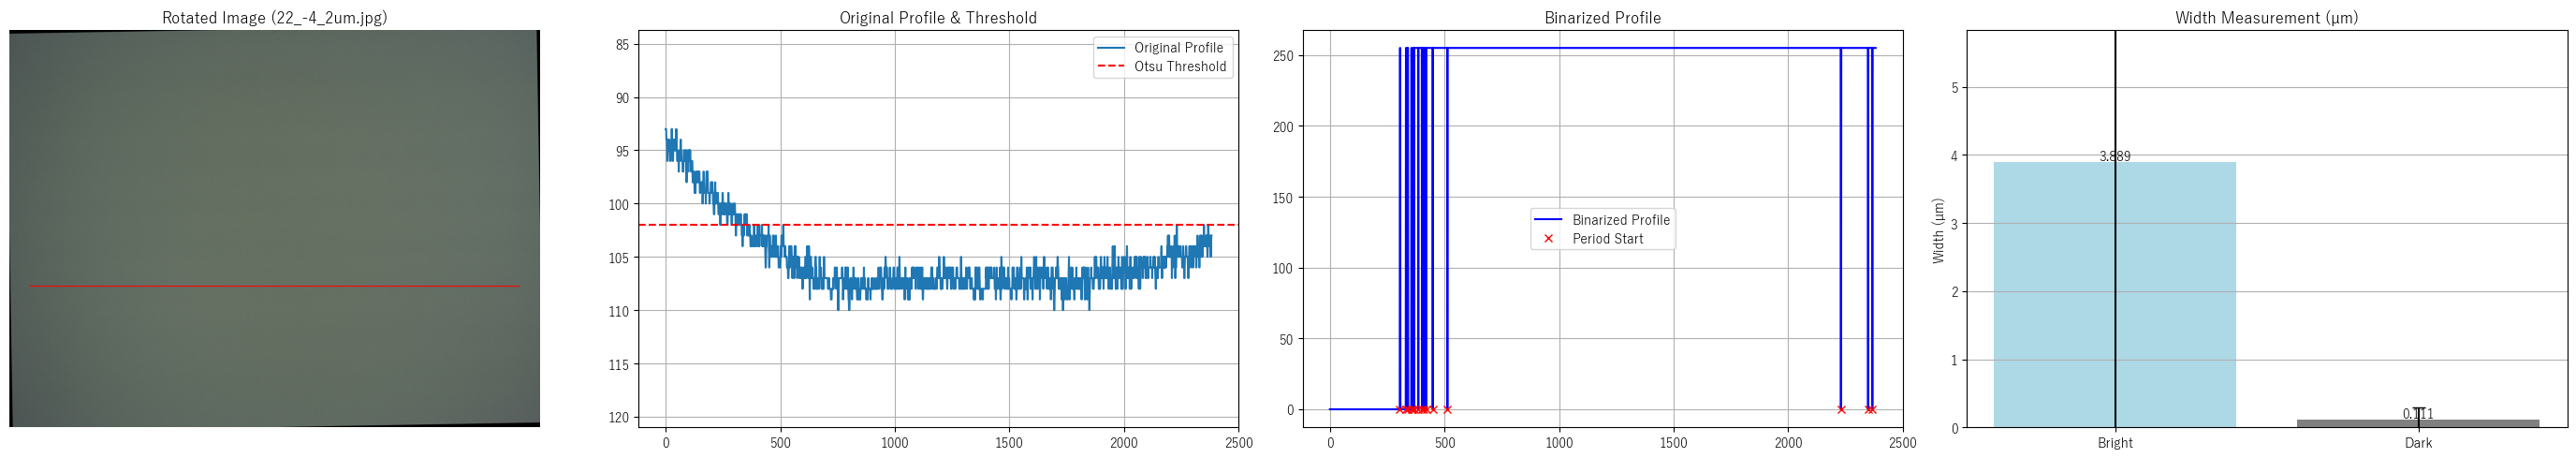


--- Processing file: 24_-4_2um.jpg ---
最終的な解析範囲: X座標 506 から 2359
ROIの端にある不完全な線を除外しました (全41本中、39本を解析)。
検出された周期の数: 19個
測定された平均周期: 90.53 ピクセル
補正後のスケール: 0.04419 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 2.602 ± 0.143 µm
暗い線の平均幅 (誤差は標準偏差): 1.405 ± 0.215 µm


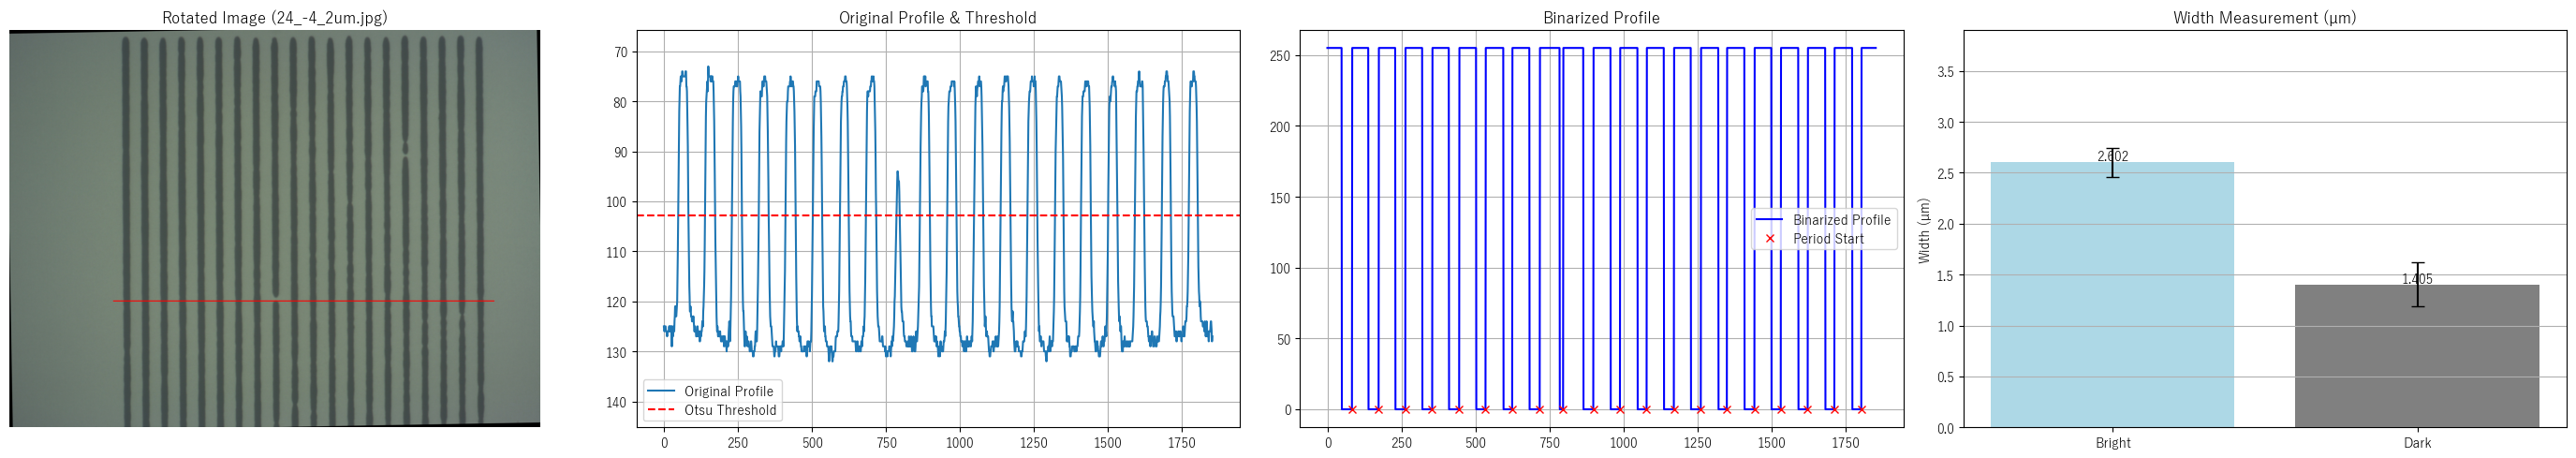


--- Processing file: 26_-4_2um.jpg ---
最終的な解析範囲: X座標 526 から 2387
ROIの端にある不完全な線を除外しました (全41本中、39本を解析)。
検出された周期の数: 19個
測定された平均周期: 90.58 ピクセル
補正後のスケール: 0.04416 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 2.173 ± 0.023 µm
暗い線の平均幅 (誤差は標準偏差): 1.828 ± 0.026 µm


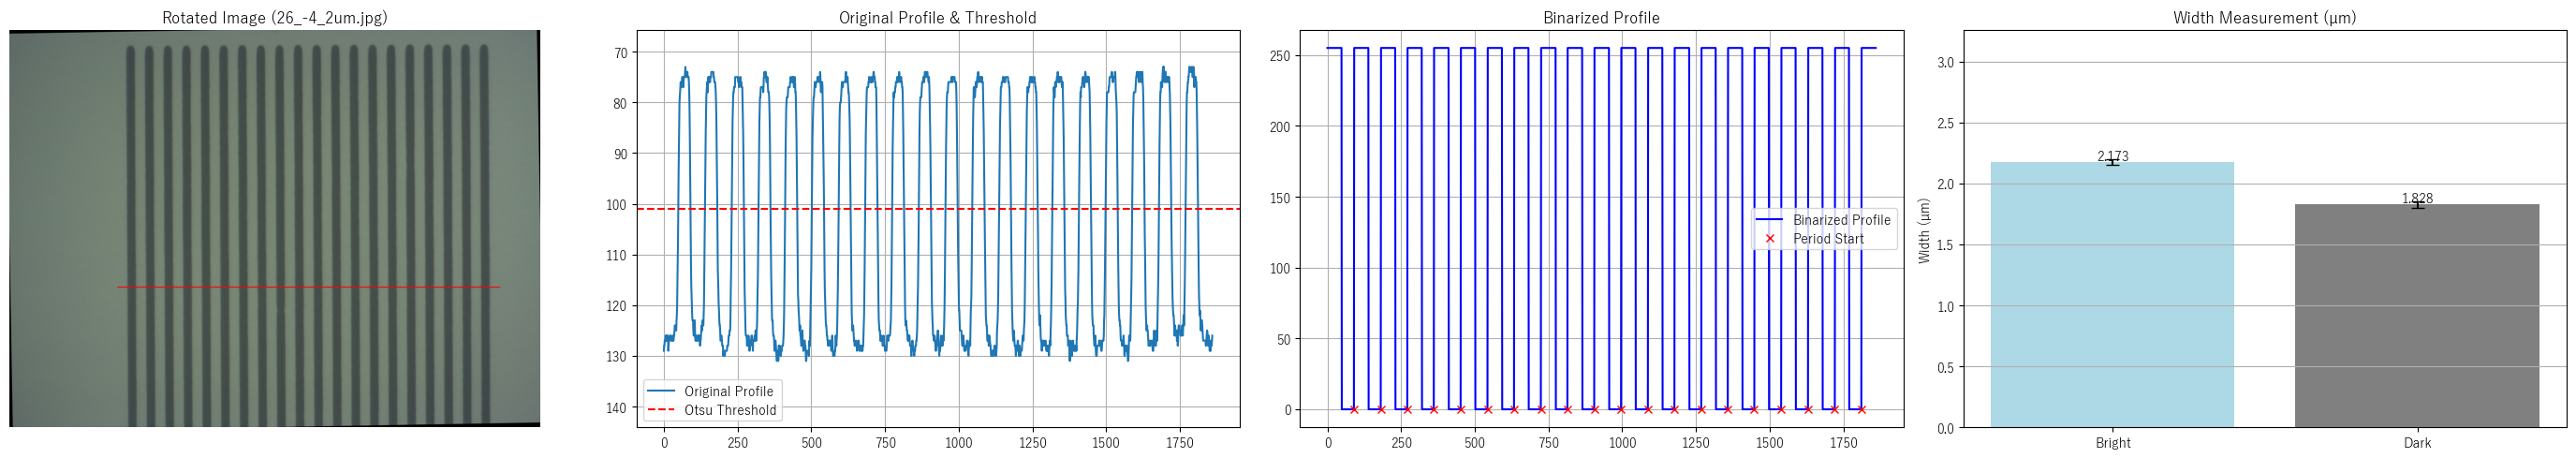

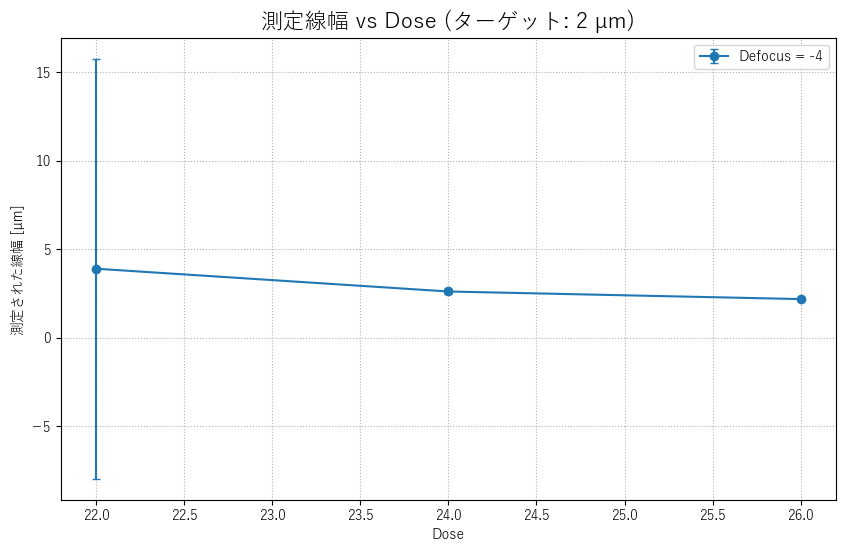

【ターゲット: 2 µm の処理が完了しました】
--------------------------------------------------

【現在処理中のターゲット: 3 µm】
-> 3 個のファイルが見つかりました。解析を開始します。

--- Processing file: 22_-4_3um.jpg ---
最終的な解析範囲: X座標 490 から 2414
ROIの端にある不完全な線を除外しました (全29本中、27本を解析)。
検出された周期の数: 13個
測定された平均周期: 135.85 ピクセル
補正後のスケール: 0.04417 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 3.374 ± 0.028 µm
暗い線の平均幅 (誤差は標準偏差): 2.628 ± 0.032 µm


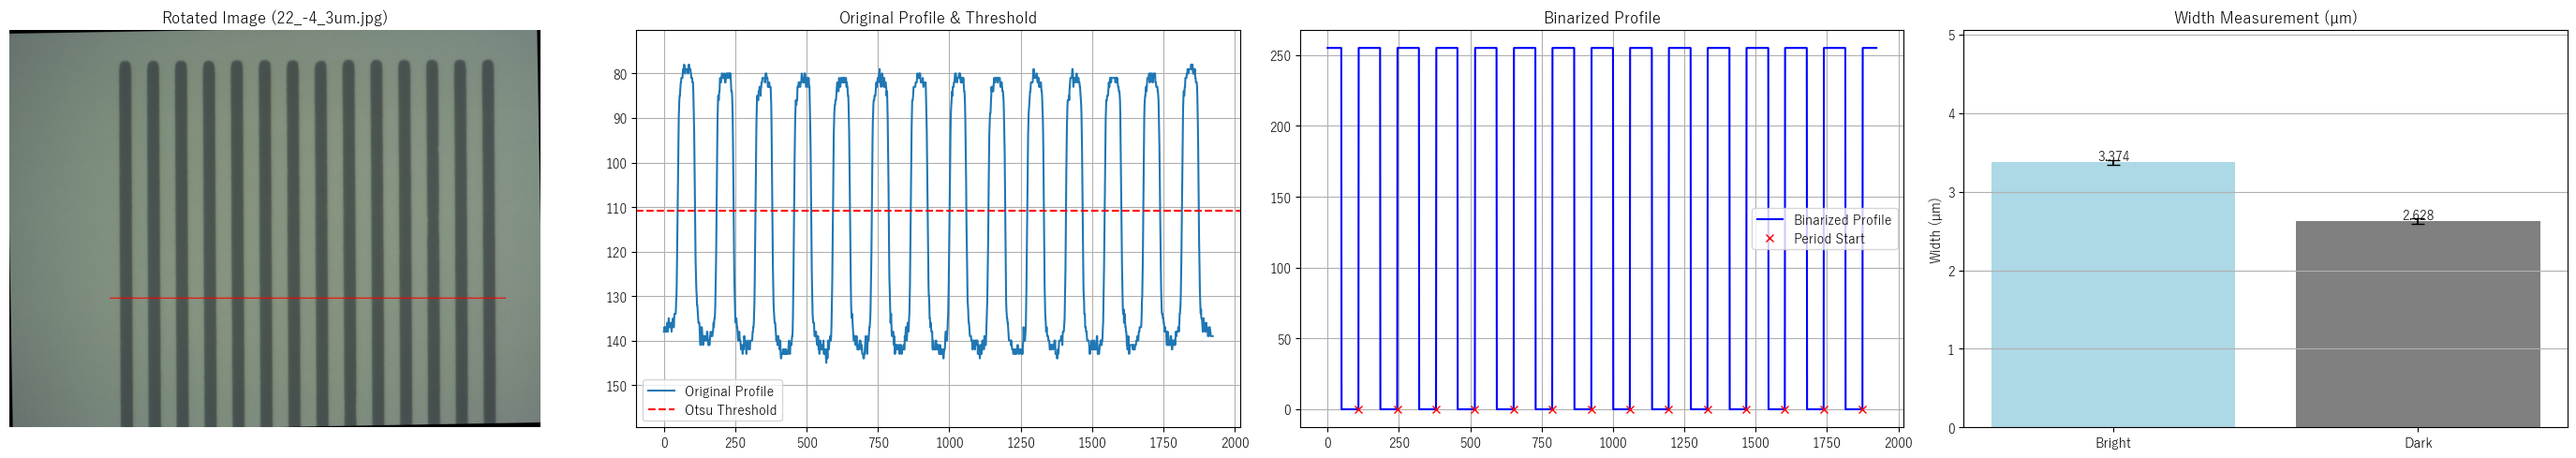


--- Processing file: 24_-4_3um.jpg ---
最終的な解析範囲: X座標 421 から 2353
ROIの端にある不完全な線を除外しました (全29本中、27本を解析)。
検出された周期の数: 13個
測定された平均周期: 135.85 ピクセル
補正後のスケール: 0.04417 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 3.020 ± 0.033 µm
暗い線の平均幅 (誤差は標準偏差): 2.981 ± 0.028 µm


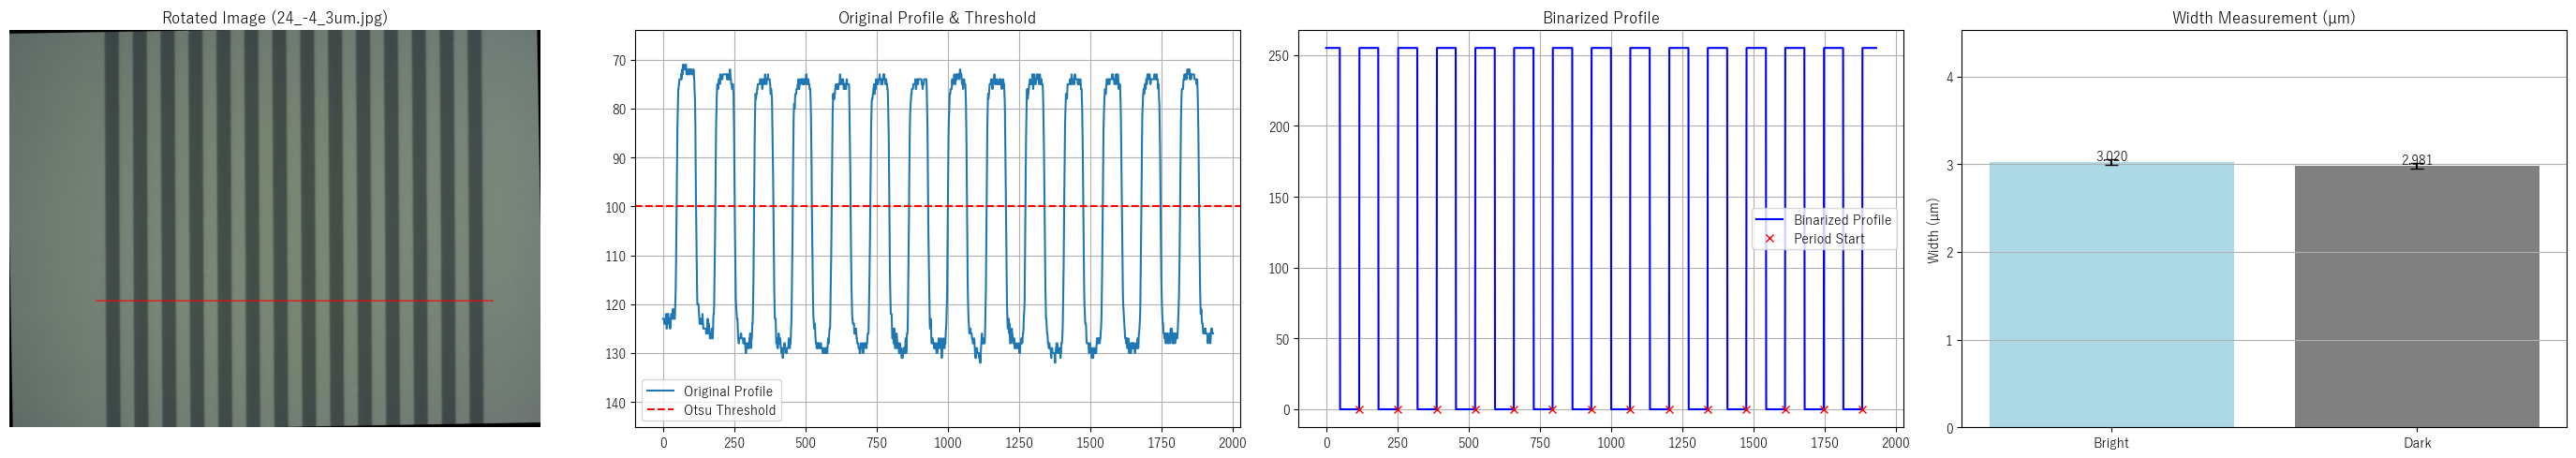


--- Processing file: 26_-4_3um.jpg ---
最終的な解析範囲: X座標 372 から 2307
ROIの端にある不完全な線を除外しました (全29本中、27本を解析)。
検出された周期の数: 13個
測定された平均周期: 135.85 ピクセル
補正後のスケール: 0.04417 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 2.901 ± 0.020 µm
暗い線の平均幅 (誤差は標準偏差): 3.101 ± 0.018 µm


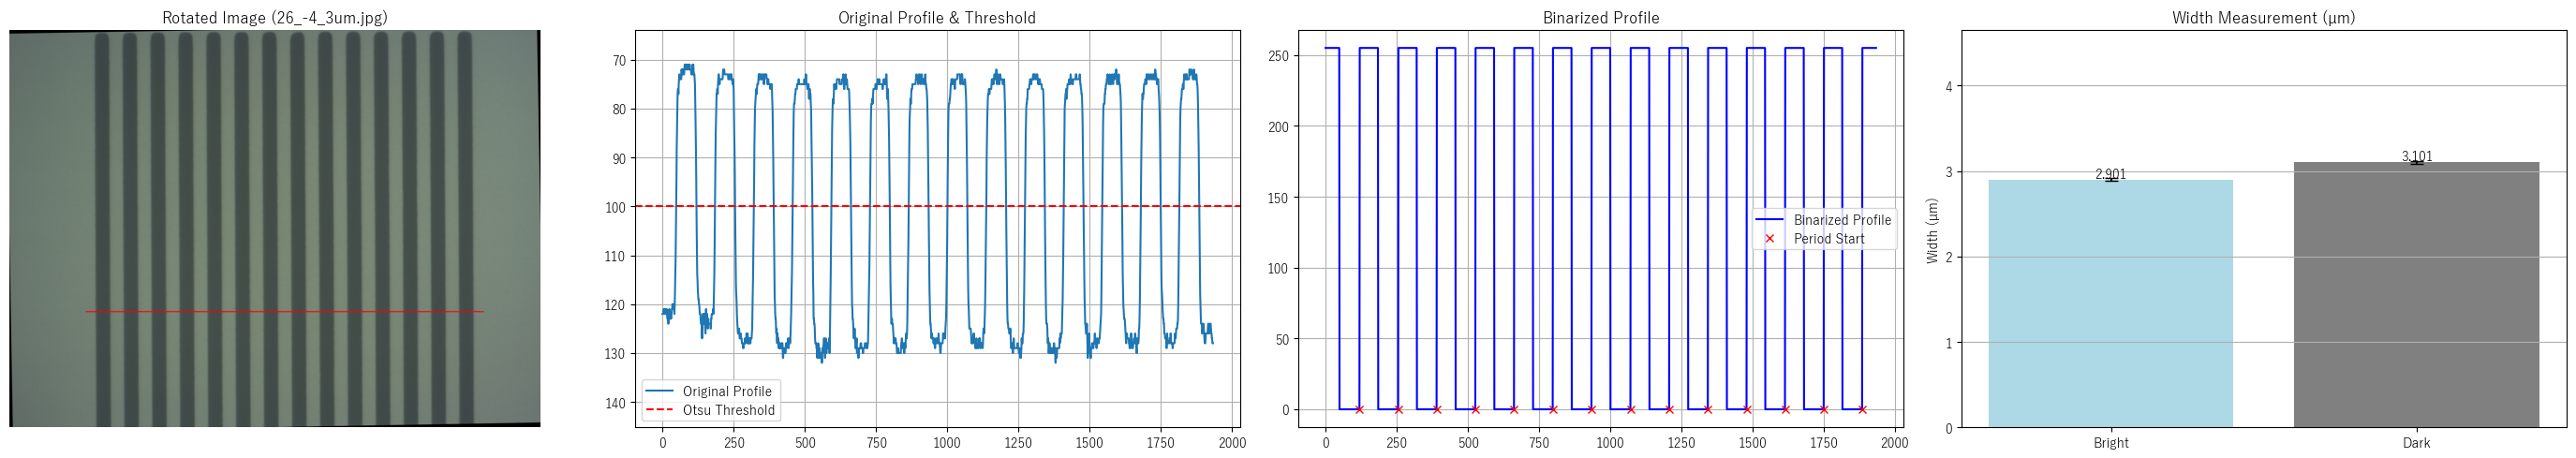

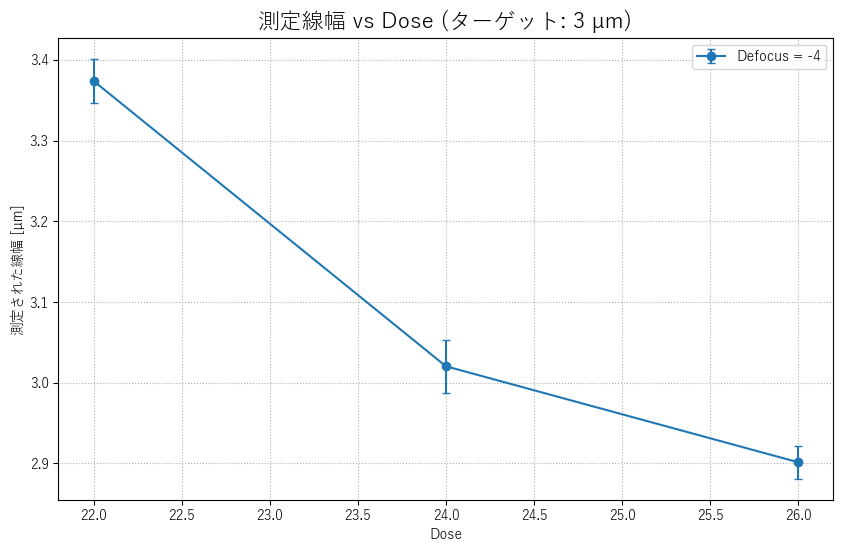

【ターゲット: 3 µm の処理が完了しました】
--------------------------------------------------

【現在処理中のターゲット: 4 µm】
-> 3 個のファイルが見つかりました。解析を開始します。

--- Processing file: 22_-4_4um.jpg ---
最終的な解析範囲: X座標 135 から 2483
ROIの端にある不完全な線を除外しました (全27本中、25本を解析)。
検出された周期の数: 12個
測定された平均周期: 181.17 ピクセル
補正後のスケール: 0.04416 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 4.260 ± 0.054 µm
暗い線の平均幅 (誤差は標準偏差): 3.731 ± 0.034 µm


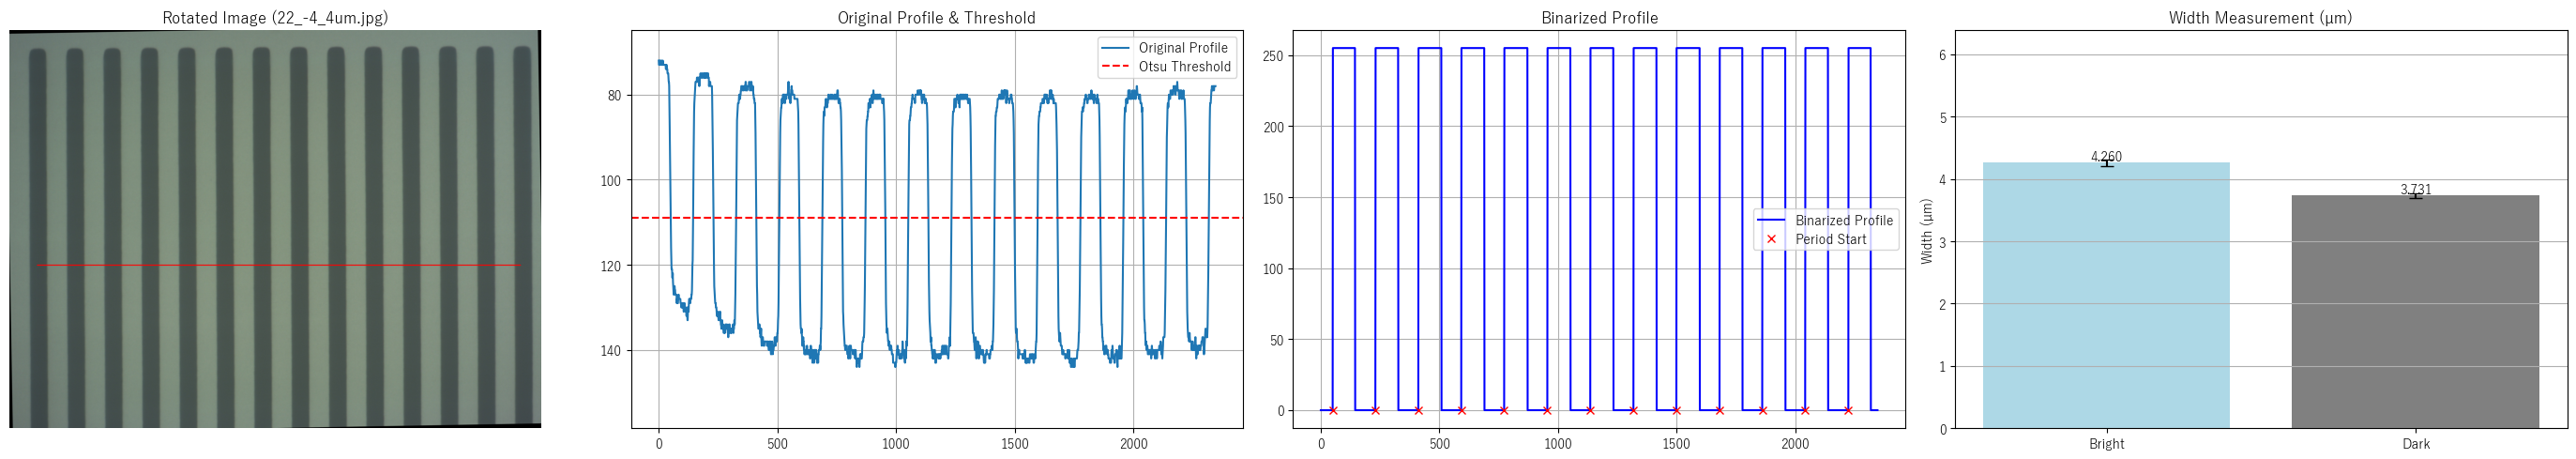


--- Processing file: 24_-4_4um.jpg ---
最終的な解析範囲: X座標 145 から 2483
ROIの端にある不完全な線を除外しました (全27本中、25本を解析)。
検出された周期の数: 12個
測定された平均周期: 181.25 ピクセル
補正後のスケール: 0.04414 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 3.925 ± 0.034 µm
暗い線の平均幅 (誤差は標準偏差): 4.081 ± 0.033 µm


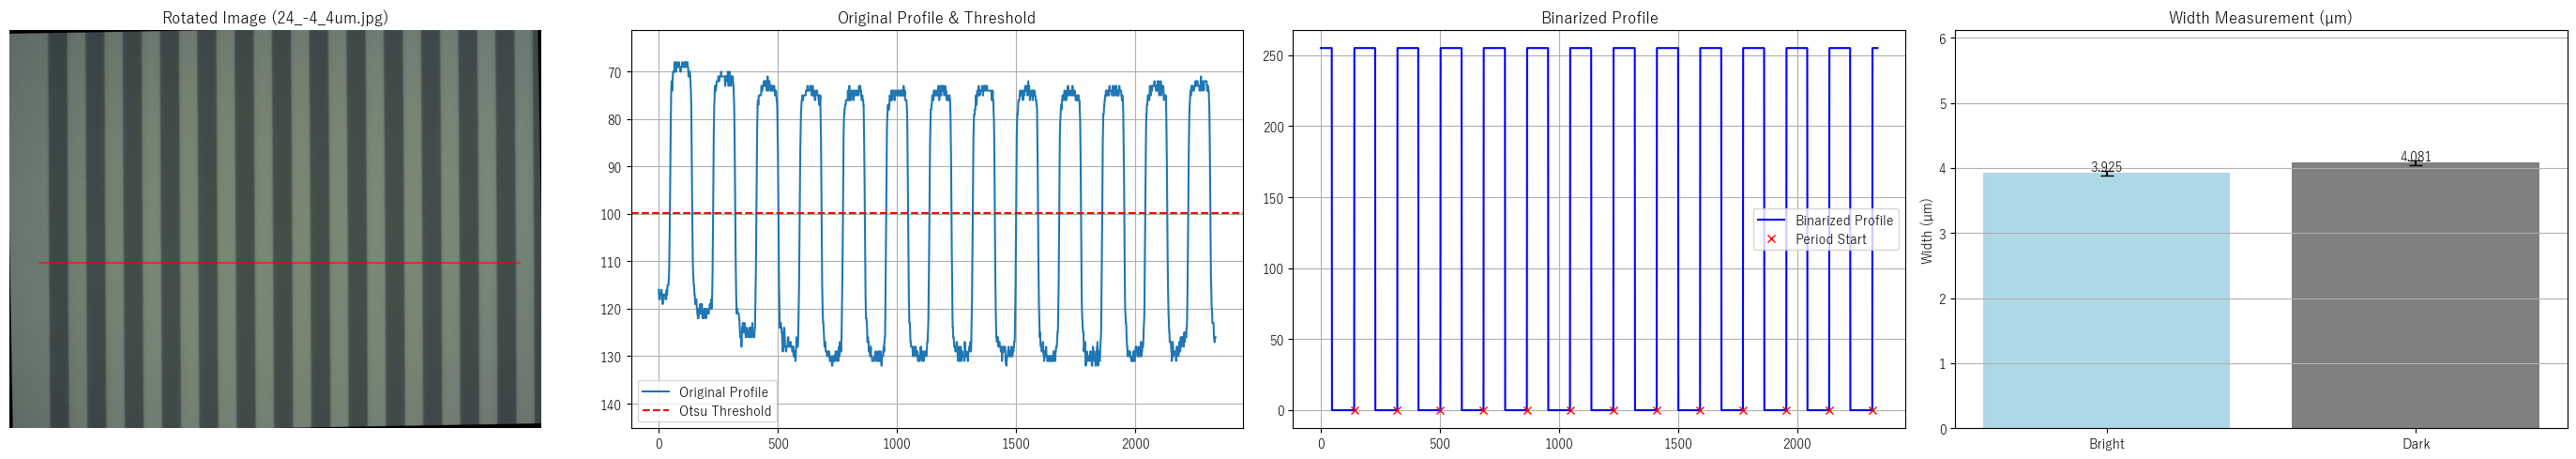


--- Processing file: 26_-4_4um.jpg ---
最終的な解析範囲: X座標 111 から 2479
ROIの端にある不完全な線を除外しました (全27本中、25本を解析)。
検出された周期の数: 12個
測定された平均周期: 181.17 ピクセル
補正後のスケール: 0.04416 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 3.834 ± 0.047 µm
暗い線の平均幅 (誤差は標準偏差): 4.175 ± 0.041 µm


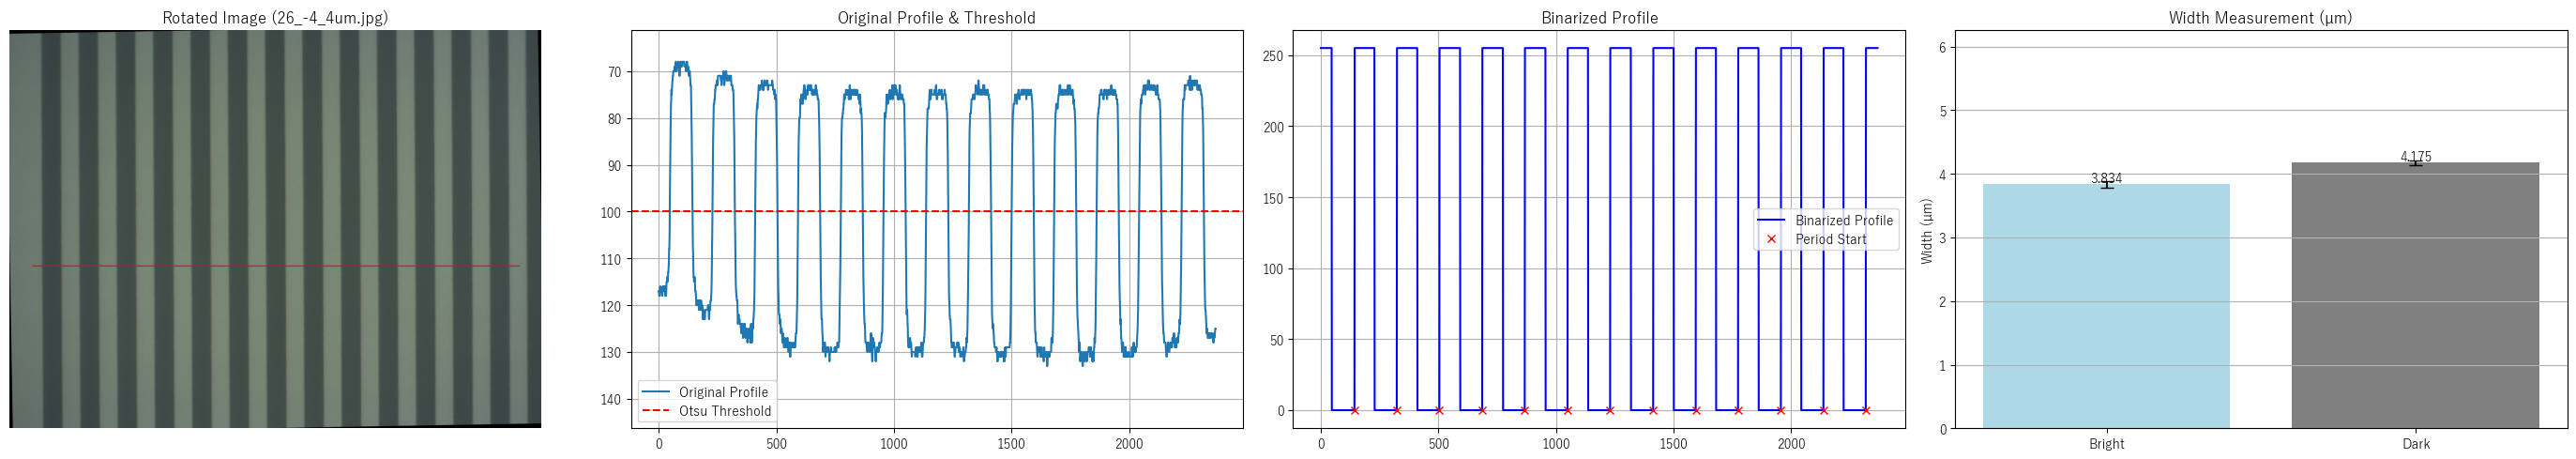

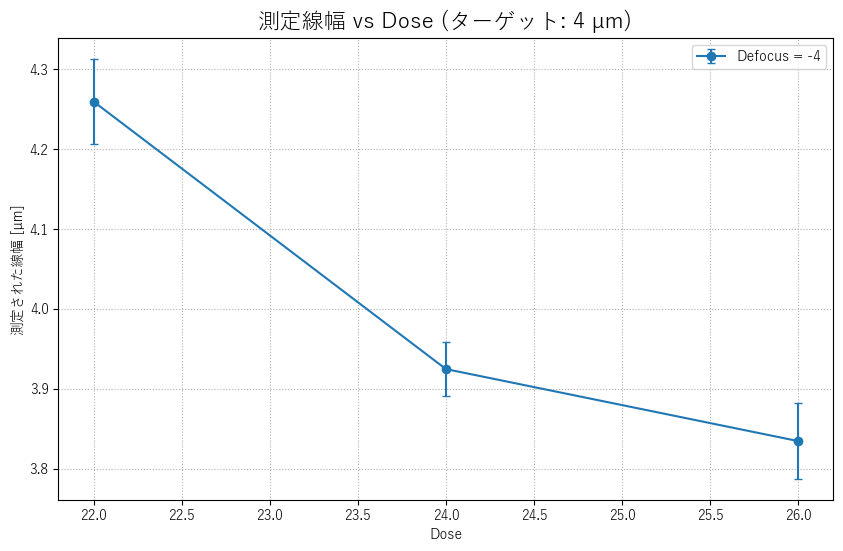

【ターゲット: 4 µm の処理が完了しました】
--------------------------------------------------

【現在処理中のターゲット: 5 µm】
-> 3 個のファイルが見つかりました。解析を開始します。

--- Processing file: 22_-4_5um.jpg ---
最終的な解析範囲: X座標 207 から 2456
ROIの端にある不完全な線を除外しました (全21本中、19本を解析)。
検出された周期の数: 9個
測定された平均周期: 226.44 ピクセル
補正後のスケール: 0.04416 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 5.064 ± 0.047 µm
暗い線の平均幅 (誤差は標準偏差): 4.946 ± 0.048 µm


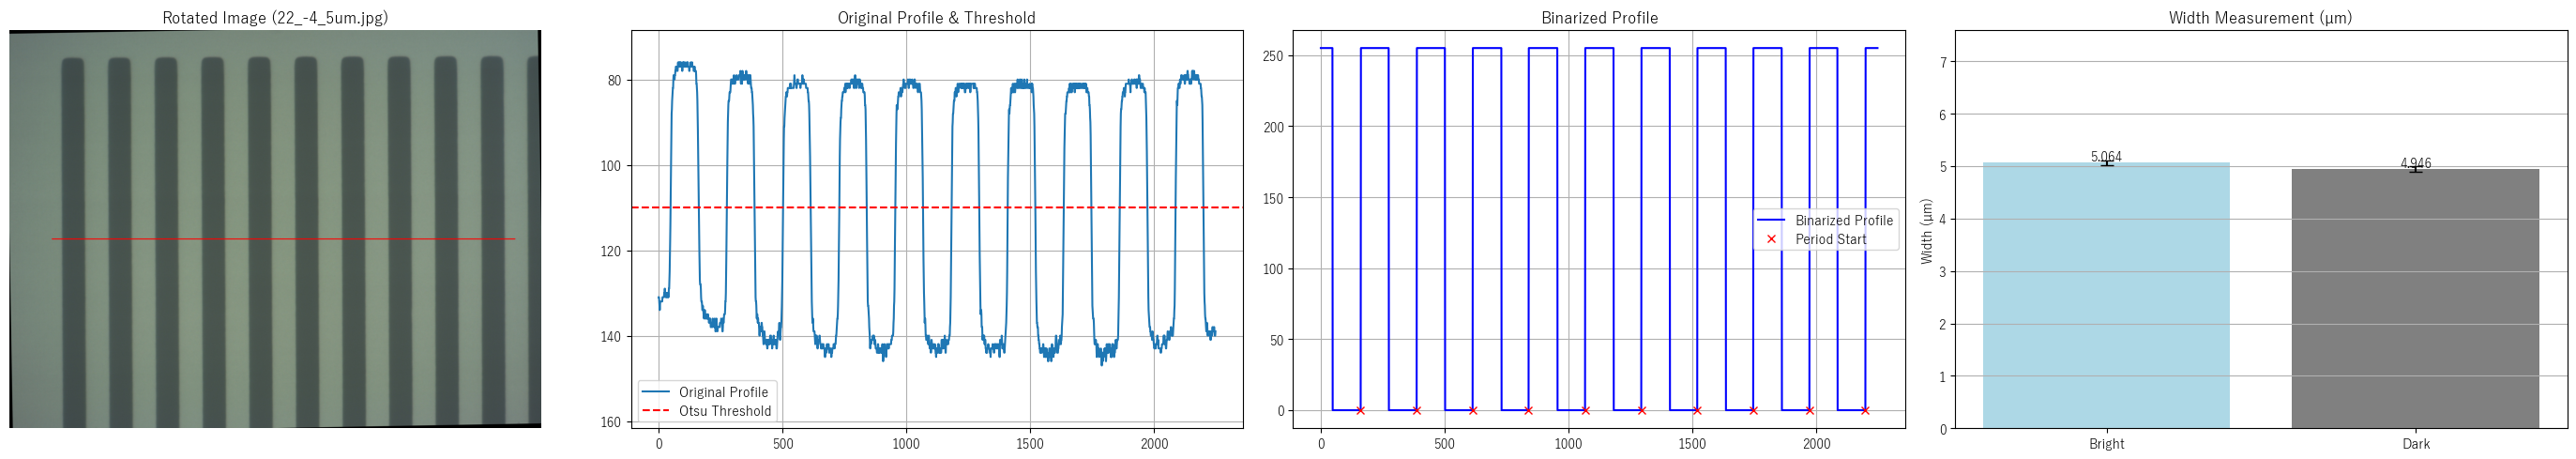


--- Processing file: 24_-4_5um.jpg ---
最終的な解析範囲: X座標 100 から 2458
ROIの端にある不完全な線を除外しました (全22本中、20本を解析)。
検出された周期の数: 9個
測定された平均周期: 226.56 ピクセル
補正後のスケール: 0.04414 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 4.952 ± 0.055 µm
暗い線の平均幅 (誤差は標準偏差): 5.045 ± 0.044 µm


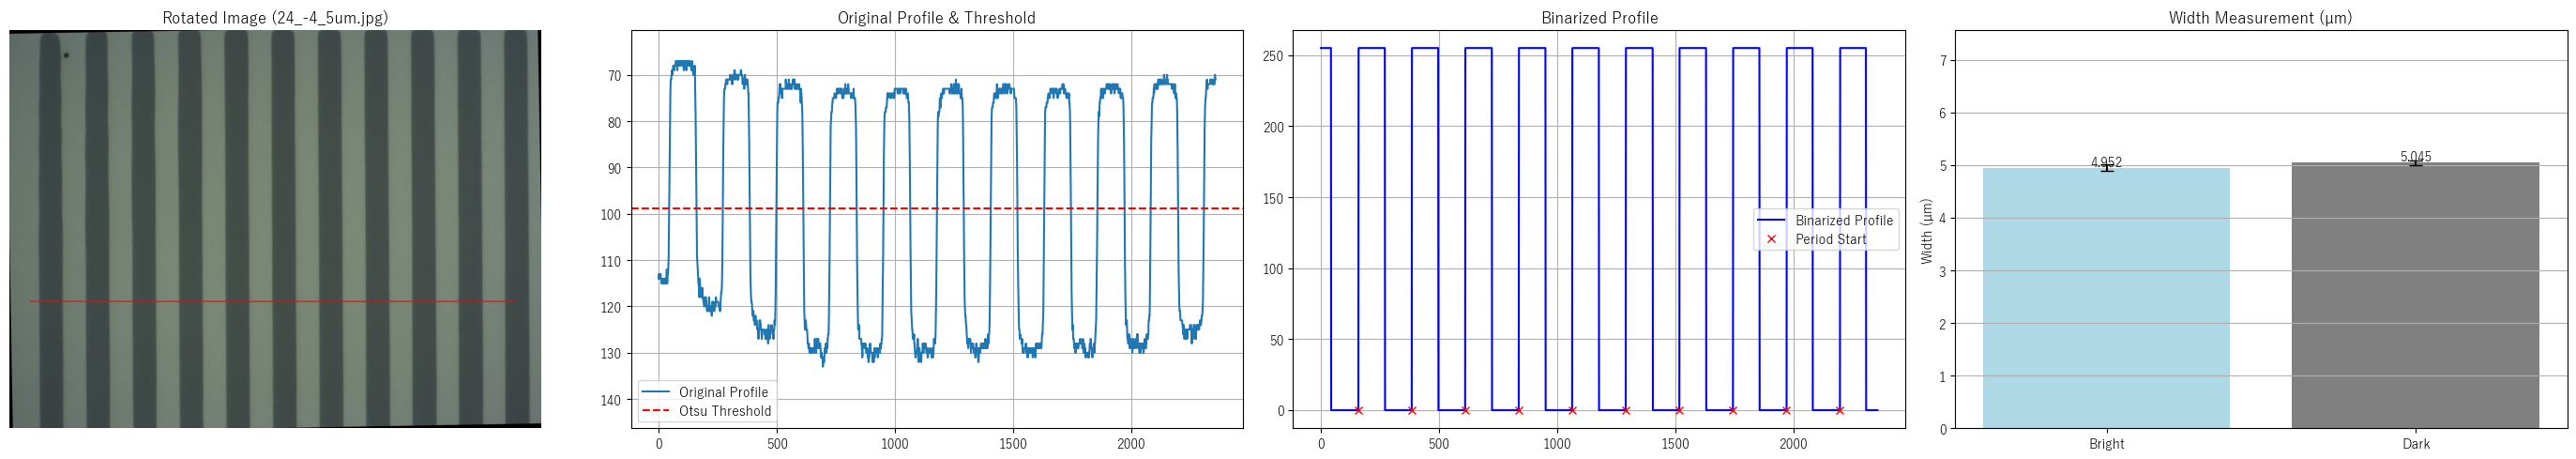


--- Processing file: 26_-4_5um.jpg ---
最終的な解析範囲: X座標 100 から 2420
ROIの端にある不完全な線を除外しました (全22本中、20本を解析)。
検出された周期の数: 9個
測定された平均周期: 226.33 ピクセル
補正後のスケール: 0.04418 µm/pixel
明るい線の平均幅 (誤差は標準偏差): 4.763 ± 0.043 µm
暗い線の平均幅 (誤差は標準偏差): 5.249 ± 0.055 µm


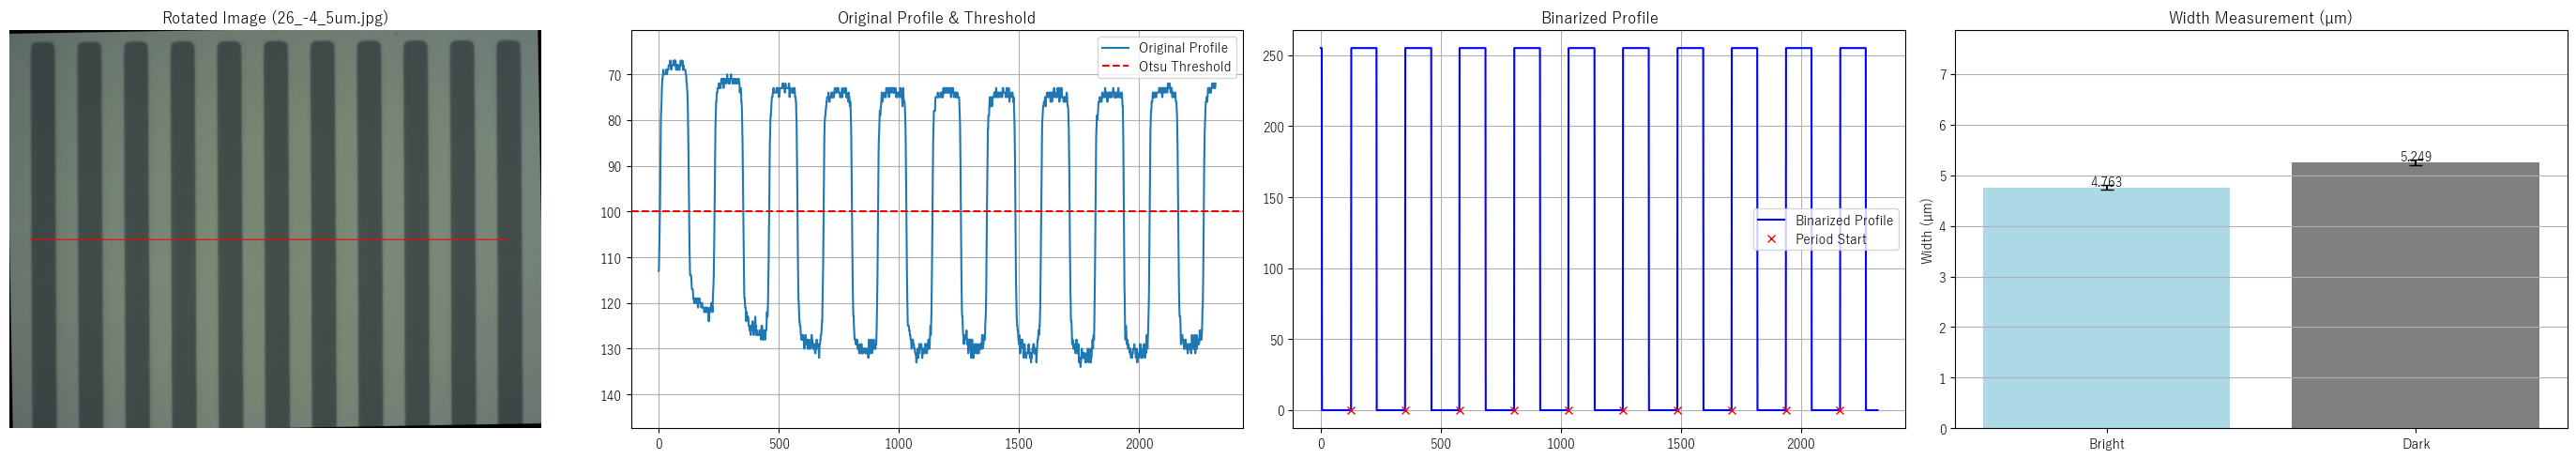

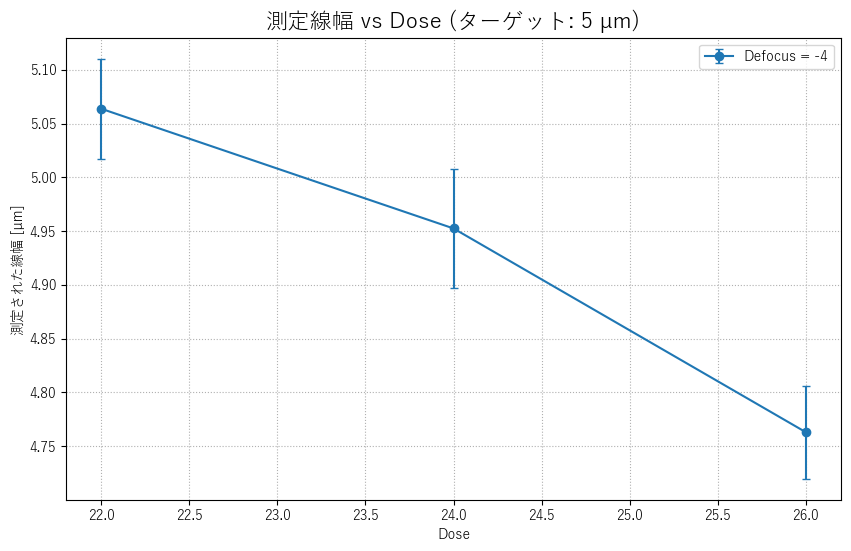

【ターゲット: 5 µm の処理が完了しました】
--------------------------------------------------

===== 全てのターゲットの解析が完了しました =====


In [26]:
# メイン処理
print(f"処理対象フォルダ: {INPUT_DIR}"); print(f"処理対象のターゲット: {TARGETS_TO_PROCESS} µm"); print("="*50)

for target_um_to_process in TARGETS_TO_PROCESS:
    print(f"\n【現在処理中のターゲット: {target_um_to_process} µm】")
    # (ファイルフィルタリング部分は変更なし)
    all_files_in_dir = os.listdir(INPUT_DIR)
    files_to_process_for_target = []
    for filename in all_files_in_dir:
        try:
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')): continue
            base_name = os.path.splitext(filename)[0]
            current_target_um = float(base_name.split('_')[2].replace('um', ''))
            if current_target_um == target_um_to_process: files_to_process_for_target.append(filename)
        except Exception: continue
    if not files_to_process_for_target: print(f"-> {target_um_to_process} µm に合致するファイルが見つかりませんでした。スキップします。"); continue
    print(f"-> {len(files_to_process_for_target)} 個のファイルが見つかりました。解析を開始します。")

    current_target_results = []
    for filename in files_to_process_for_target:
        try:
            print(f"\n--- Processing file: {filename} ---")
            params = os.path.splitext(filename)[0].split('_'); dose_val, defocus_val, target_um_val = int(params[0]), int(params[1]), float(params[2].replace('um', ''))
            target_period_um = target_um_val * 2.0
            rotated_color, rotated_gray = load_and_rotate_image(os.path.join(INPUT_DIR, filename), ROTATION_ANGLE)
            if rotated_gray is None: continue
            roi_gray = rotated_gray[ROI_RECT['y']:ROI_RECT['y']+ROI_RECT['h'], ROI_RECT['x']:ROI_RECT['x']+ROI_RECT['w']]
            scan_line_y = ROI_RECT['y'] + np.argmax(np.sum(np.abs(cv2.Sobel(roi_gray, cv2.CV_64F, 0, 1, ksize=3)), axis=1))
            full_profile = rotated_gray[scan_line_y, :].astype(np.float32)
            analysis_range = find_analysis_range(full_profile, WINDOW_SIZE, THRESHOLD_RATIO, SEARCH_MARGIN_PIXELS)
            if analysis_range is None: print("解析範囲を検出できませんでした。スキップします。"); continue
            print(f"最終的な解析範囲: X座標 {analysis_range[0]} から {analysis_range[1]}")
            profile_to_analyze = full_profile[analysis_range[0]:analysis_range[1]]
            analysis_results = analyze_profile(profile_to_analyze, target_period_um)
            if analysis_results is None: print("プロファイルの解析に失敗しました。スキップします。"); continue
            
            print(f"検出された周期の数: {analysis_results['num_periods']}個"); print(f"測定された平均周期: {analysis_results['avg_period_px']:.2f} ピクセル"); print(f"補正後のスケール: {analysis_results['pixel_to_um']:.5f} µm/pixel")
            print(f"明るい線の平均幅 (誤差は標準偏差): {analysis_results['avg_bright_um']:.3f} ± {analysis_results['std_bright_um']:.3f} µm")
            print(f"暗い線の平均幅 (誤差は標準偏差): {analysis_results['avg_dark_um']:.3f} ± {analysis_results['std_dark_um']:.3f} µm")
        
            roi_for_plot = {'y_coord': scan_line_y, 'x_start': analysis_range[0], 'x_end': analysis_range[1]}
            plot_results(rotated_color, profile_to_analyze, analysis_results, filename, roi_for_plot)
            
            current_result = {'dose': dose_val, 'defocus': defocus_val, 'target_um': target_um_val}
            current_result.update(analysis_results)
            current_target_results.append(current_result)
        except Exception as e:
            print(f"  - 警告: ファイル '{filename}' の処理中に予期せぬエラーが発生しました ({e})。スキップします。")
            continue

    if current_target_results:
        df_current_target = pd.DataFrame(current_target_results)
        plt.figure(figsize=(10, 6))
        for defocus_val in sorted(df_current_target['defocus'].unique()):
            df_defocus = df_current_target[df_current_target['defocus'] == defocus_val].sort_values(by='dose')
            plt.errorbar(x=df_defocus['dose'], y=df_defocus['avg_bright_um'], yerr=df_defocus['std_bright_um'], marker='o', linestyle='-', capsize=3, label=f'Defocus = {defocus_val}')
        plt.title(f'測定線幅 vs Dose (ターゲット: {target_um_to_process} µm)', fontsize=16)
        plt.xlabel('Dose'), plt.ylabel('測定された線幅 [µm]'), plt.grid(True, linestyle=':'), plt.legend(), plt.show()
    
    print(f"【ターゲット: {target_um_to_process} µm の処理が完了しました】"); print("-" * 50)

print("\n===== 全てのターゲットの解析が完了しました =====")